In [1]:
import sqlite3
import pandas as pd
import plotly.express as px

In [2]:
conn = sqlite3.connect("badge_attendance.db")


## Monthly Attendance Trend

This line chart shows the overall trend of total attendance hours across
months.


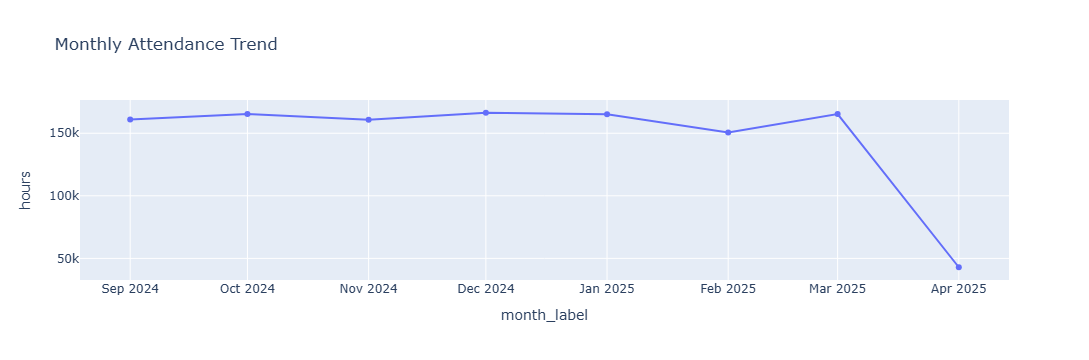

In [3]:
query = """
SELECT
    c.year,
    c.month,
    SUM(f.total_hours) as hours
FROM fact_attendance_daily f
JOIN dim_calendar c
ON f.date_id = c.date_id
GROUP BY c.year, c.month
ORDER BY c.year, c.month
"""

df_month = pd.read_sql(query, conn)

df_month["month_label"] = df_month["year"].astype(str) + "-" + df_month["month"].astype(str)

fig = px.line(df_month,
              x="month_label",
              y="hours",
              title="Monthly Attendance Trend",
              markers=True)

fig.show()


## Subject-wise Attendance Trend (Month-over-Month)

This line chart compares attendance trends across different subjects,
showing how total attendance hours vary by department over time.

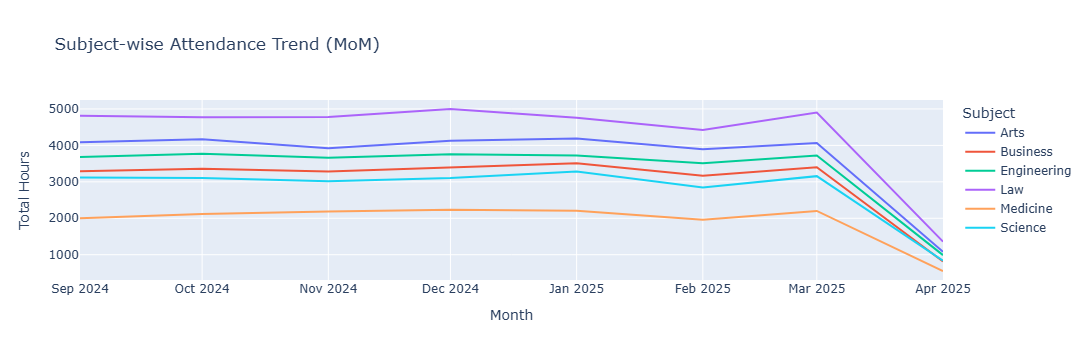

In [4]:
query = """
SELECT
    c.year,
    c.month,
    t.department AS subject,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_calendar c
    ON f.date_id = c.date_id
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY c.year, c.month, t.department
ORDER BY c.year, c.month;
"""

df = pd.read_sql(query, conn)

df["month_label"] = df["year"].astype(str) + "-" + df["month"].astype(str)

fig = px.line(
    df,
    x="month_label",
    y="total_hours",
    color="subject",
    title="Subject-wise Attendance Trend (MoM)"
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Total Hours",
    legend_title="Subject"
)

fig.show()


## Teacher-wise Attendance Trend (Month-over-Month)

This line chart shows month-over-month attendance trends for top 5
teachers, illustrating variations in teaching activity over time.


In [5]:
query = """
SELECT
    c.year,
    c.month,
    t.name AS teacher_name,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_calendar c
    ON f.date_id = c.date_id
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY c.year, c.month, t.name
ORDER BY c.year, c.month;
"""

df = pd.read_sql(query, conn)

df["month_label"] = df["year"].astype(str) + "-" + df["month"].astype(str)

# Pick only top 5 teachers overall for cleaner chart
top_teachers = (
    df.groupby("teacher_name")["total_hours"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index
)

df_top = df[df["teacher_name"].isin(top_teachers)]

fig = px.line(
    df_top,
    x="month_label",
    y="total_hours",
    color="teacher_name",
    title="Month-over-Month Trend for Top 5 Teachers"
)

fig.show()


## Subject-wise Attendance Distribution

This pie chart represents the proportion of total attendance hours
across different academic departments, helping identify dominant subjects
in campus activity.


In [6]:
query = """
SELECT
    t.department AS subject,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY t.department;
"""

# Load result into dataframe
df = pd.read_sql_query(query, conn)

# Create Pie Chart
fig = px.pie(
    df,
    names="subject",
    values="total_hours",
    title="Subject-wise Attendance Distribution",
    hole=0.25
)

fig.show()

## Comparative Attendance: Students vs Teachers

This chart compares total attendance hours between students and teachers,
providing insight into engagement patterns across roles.


In [7]:
query = """
SELECT
    CASE
        WHEN f.badge_id IN (SELECT badge_id FROM dim_teachers) THEN 'Teacher'
        ELSE 'Student'
    END AS person_type,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
GROUP BY person_type;
"""

df = pd.read_sql_query(query, conn)

fig = px.bar(
    df,
    x="person_type",
    y="total_hours",
    title="Comparative Analysis: Student vs Teacher Attendance",
    labels={"person_type": "Category", "total_hours": "Total Hours"}
)

fig.show()

## Top 10 Students by Attendance

This bar chart highlights the top 10 students based on total attendance
hours, indicating the most consistently present students on campus.


In [8]:
query = """
SELECT
    s.name AS student_name,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_students s
    ON f.badge_id = s.badge_id
GROUP BY s.name
ORDER BY total_hours DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)

fig = px.bar(
    df,
    x="student_name",
    y="total_hours",
    title="Top 10 Students by Attendance Hours",
    labels={"student_name": "Student Name", "total_hours": "Total Hours"},
    text="total_hours"
)

fig.update_traces(textposition="outside")
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [11]:
query = """
SELECT
    s.name AS student_name,
    s.department,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_students s
    ON f.badge_id = s.badge_id
GROUP BY s.name, s.department
ORDER BY total_hours DESC
LIMIT 10;
"""

top_students_df = pd.read_sql(query, conn)
top_students_df


,student_name,department,total_hours
0,James Davis,Law,1108.033333
1,Jeffrey Mitchell,Arts,1064.316667
2,Michael King,Arts,1010.850000
3,John Wright,Engineering,1004.900000
4,Anthony Johnson,Science,969.383333
5,Valerie Jones,Arts,958.233333
6,Joshua Hamilton,Business,931.966667
7,Samantha Collins,Medicine,659.050000
8,Chad Jennings,Law,647.016667
9,Anthony Rasmussen,Engineering,634.583333


In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')

table = ax.table(
    cellText=top_students_df.values,
    colLabels=top_students_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

plt.savefig("top_10_students.png", bbox_inches="tight", dpi=300)
plt.close()


In [13]:
query = """
SELECT
    t.name AS teacher_name,
    t.department AS subject,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY t.name, t.department
ORDER BY total_hours DESC
LIMIT 10;
"""

top_teachers_df = pd.read_sql(query, conn)
top_teachers_df


,teacher_name,subject,total_hours
0,Crystal Williams,Science,1148.633333
1,Gina Pearson,Engineering,1139.166667
2,Kathleen Savage,Law,1121.083333
3,Shane Martin,Arts,1119.383333
4,Tyler Bush,Engineering,1109.366667
5,Alejandro Baker,Law,1100.583333
6,Christopher Young,Business,1100.233333
7,Elizabeth Page,Law,1097.900000
8,Daniel Gates,Science,1097.666667
9,Mark Hernandez,Engineering,1097.100000


In [14]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')

table = ax.table(
    cellText=top_teachers_df.values,
    colLabels=top_teachers_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

plt.savefig("top_10_teachers.png", bbox_inches="tight", dpi=300)
plt.close()


In [7]:
query = """
SELECT
    s.name AS student_name,
    s.department,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_students s
    ON f.badge_id = s.badge_id
GROUP BY s.name, s.department
ORDER BY total_hours ASC
LIMIT 5;
"""

lowest_students_df = pd.read_sql(query, conn)
lowest_students_df

,student_name,department,total_hours
0,Cynthia Dyer,Business,374.533333
1,Eric Stewart,Business,390.116667
2,Megan Rodriguez,Business,393.816667
3,Marilyn Goodman,Medicine,395.300000
4,Jim Ross,Engineering,397.300000


In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')

table = ax.table(
    cellText=lowest_students_df.values,
    colLabels=lowest_students_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

plt.savefig("lowest_5_students.png", bbox_inches="tight", dpi=300)
plt.close()

In [12]:
query = """
SELECT
    t.name AS teacher_name,
    t.department AS subject,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY t.name, t.department
ORDER BY total_hours ASC
LIMIT 5;
"""

lowest_teachers_df = pd.read_sql(query, conn)
lowest_teachers_df


,teacher_name,subject,total_hours
0,Dalton Arnold,Law,887.966667
1,Charles Perry,Arts,928.350000
2,Stephanie Newman,Science,935.066667
3,Cheryl Griffith,Arts,936.366667
4,Eric Harris,Law,937.450000


In [13]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')

table = ax.table(
    cellText=lowest_teachers_df.values,
    colLabels=lowest_teachers_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

plt.savefig("lowest_5_teachers.png", bbox_inches="tight", dpi=300)
plt.close()
